### Bitcoin Prediction using Autoregressive Integrated Moving Average

In [4]:
#importing libraries  
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

In [5]:
#loading the data. 
df = pd.read_csv('dataset.csv')
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


In [6]:
df.dtypes

Timestamp              int64
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume_(BTC)         float64
Volume_(Currency)    float64
Weighted_Price       float64
dtype: object

In [7]:
#Unix-time to 
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')
#print(df.Timestamp)

# Resampling to daily frequency
df.index = df.Timestamp
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

In [8]:
#Now we will be using timestamp converted to months for our analysis out of all the above conversion

df_month.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31,4.472552,4.472624,4.472552,4.472624,7.590527,34.069690,4.472579
2012-01-31,6.235412,6.239745,6.231737,6.236086,4.955810,29.527545,6.234949
2012-02-29,5.234146,5.234743,5.231709,5.232306,7.153212,37.120786,5.232734
2012-03-31,4.960839,4.961539,4.953547,4.953967,13.455398,66.445048,4.958308
2012-04-30,4.980709,4.982016,4.979536,4.980802,18.732216,92.674707,4.980866


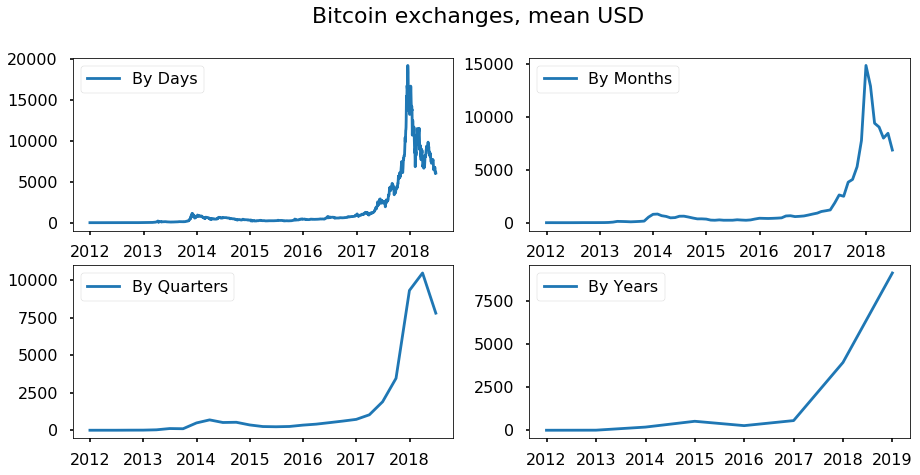

In [9]:
# PLOTS the timestamped data, in various different forms - days, months, quaters, yearly
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.Weighted_Price, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.Weighted_Price, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Weighted_Price, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

In [10]:
# splitting dataset in 2/3 for training and 1/3 for testing purpose

split = 50
df_train = df_month[:split]
df_test = df_month[split:len(df_month)]

Dickey–Fuller test: p=0.470285


<Figure size 1080x504 with 0 Axes>

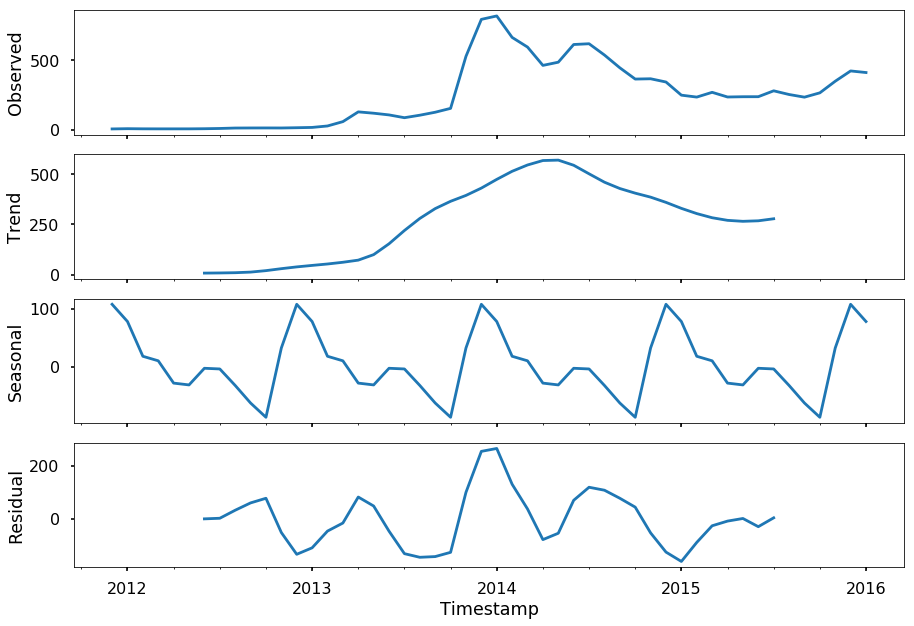

In [11]:
# All the Timeseries algorithms works well with Stationary Dataset (add definitation)
# Also add definination of non-stationary dataset

# We are using Dicky-Fully Test to check whether a dataset is stationary of not 
# if val<0.05, then the dataset is stationary
# else, dataset set is stationary

# To make a dataset stationary we will perform various transforms and 
# to predict the final output we will be performing the inverse of those transforms

# Stationarity check for Original Dataset

plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_train.Weighted_Price).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_train.Weighted_Price)[1])
plt.show()

In [12]:
# Now we are performing Box-Cox transform and then check whether the dataset has become stationary or not

# Box-Cox Transformations 

df_train['Weighted_Price_box'], lmbda = stats.boxcox(df_train.Weighted_Price)

# Stationary Check again the value is more than 0.05

print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_train.Weighted_Price)[1])

Dickey–Fuller test: p=0.470285


In [13]:
#Now we are performing Seasonal

#Seasonal differentiation

df_train['prices_box_diff'] = df_train.Weighted_Price_box - df_train.Weighted_Price_box.shift(12)

print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_train.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.104669


Dickey–Fuller test: p=0.003063


<Figure size 1080x504 with 0 Axes>

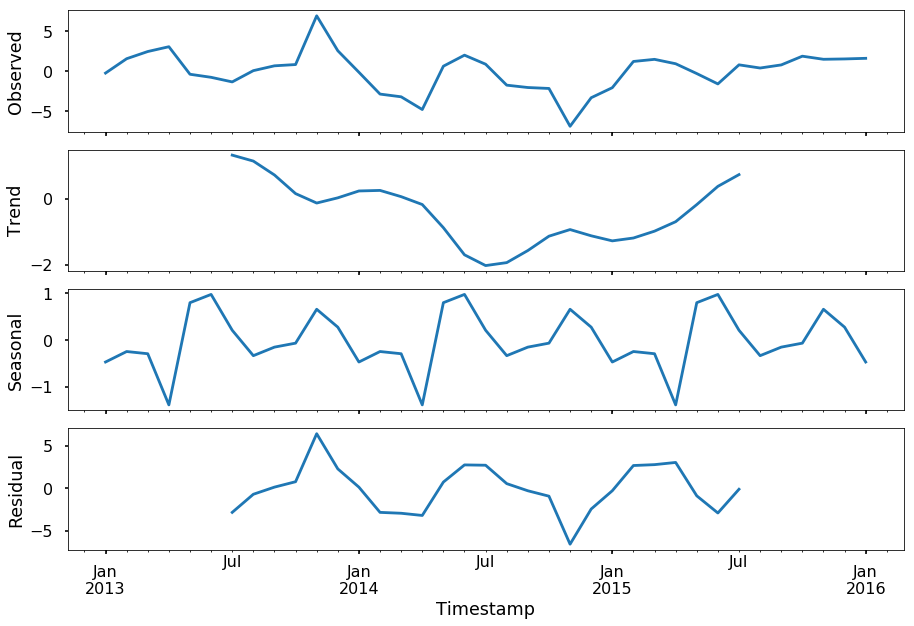

In [14]:
# Regular differentiation

df_train['prices_box_diff2'] = df_train.prices_box_diff - df_train.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(df_train.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_train.prices_box_diff2[13:])[1])

plt.show()

In [15]:
# Initial approximation of parameters

Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
# print(parameters_list)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_train.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        continue
    aic = model.aic
    # print(aic)
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [16]:
# Best Models

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

print(best_model.summary())

      parameters         aic
16  (1, 0, 2, 0)  140.162438
6   (0, 1, 2, 0)  140.805783
11  (0, 2, 2, 0)  141.159720
31  (2, 0, 2, 0)  141.525079
21  (1, 1, 2, 0)  141.815364
                                 Statespace Model Results                                 
Dep. Variable:                 Weighted_Price_box   No. Observations:                   50
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood                 -66.081
Date:                            Mon, 05 Nov 2018   AIC                            140.162
Time:                                    12:13:20   BIC                            146.606
Sample:                                12-31-2011   HQIC                           142.434
                                     - 01-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

Dickey–Fuller test:: p=0.000013


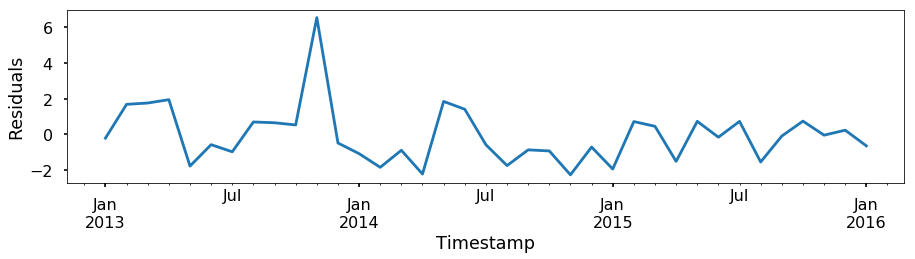

In [17]:
# STL-decomposition

from pandas import Series
from matplotlib import pyplot

plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

pyplot.show()

In [18]:
#Prediction 

# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

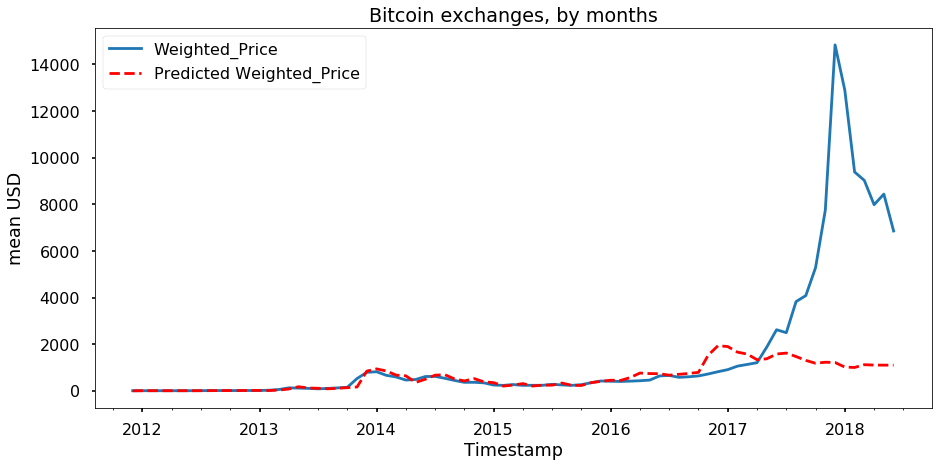

In [19]:
df_month2 = df_month[['Weighted_Price']]

df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=100), lmbda)

plt.figure(figsize=(15,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()